In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from parse import parse

from alphaMusic.utils.fls_utils import load_from_pkl
import alphaMusic.evaluation as evl

In [14]:
sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':1.5,
            'font.family': 'serif',
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(7, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)

In [8]:
path_to_results = Path('..','recipes','EUSIPCO22','results')
assert path_to_results.exists()

files = path_to_results.glob('N:180_RT60:0.25*DRR:sweep*.pkl')
exp_name = 'N:{n_samples}_RT60:{rt60_name}_SNR:{snr_name}_DRR:{drr_name}_nsrcs:{n_srcs}_nmics:{n_mics}_noise:{noise_type}'

results = pd.DataFrame()
for file in sorted(files):
    print(file)
    params = parse(exp_name,str(file.name))
    df = load_from_pkl(file)
    df['n_mics'] = int(params['n_mics'])
    df['n_srcs'] = int(params['n_srcs'])
    results = pd.concat([results, df], ignore_index=True)

../recipes/EUSIPCO22/results/N:180_RT60:0.25_SNR:10_DRR:sweep_nsrcs:1_nmics:4_noise:cafet_results.pkl
../recipes/EUSIPCO22/results/N:180_RT60:0.25_SNR:10_DRR:sweep_nsrcs:2_nmics:4_noise:cafet_results.pkl
../recipes/EUSIPCO22/results/N:180_RT60:0.25_SNR:10_DRR:sweep_nsrcs:3_nmics:4_noise:cafet_results.pkl
../recipes/EUSIPCO22/results/N:180_RT60:0.25_SNR:10_DRR:sweep_nsrcs:4_nmics:4_noise:cafet_results.pkl


In [9]:
df = pd.DataFrame()

for r, row in results.iterrows():
    
    # compute metrics
    doas_est = row['DOAs_est']
    doas_ref = row['DOAs']
    
    metrics = evl.compute_ssl_metrics(doas_est, doas_ref)
    
    df.at[r,'algo'] = row['algo']

    df.at[r,'MAE'] = metrics['MAE']
    df.at[r,'RMSE'] = metrics['RMSE']
    df.at[r,'ACC5'] = metrics['ACC5']
    df.at[r,'ACC10'] = metrics['ACC10']
    df.at[r,'MISS'] = metrics['MISS']
    
    # params
    df.at[r,'DRR'] = row['DRR']
    df.at[r,'SNR'] = row['SNR']
    df.at[r,'RT60'] = row['RT60']
    df.at[r,'n_mics'] = row['n_mics']
    df.at[r,'n_srcs'] = row['n_srcs']
    df.at[r,'alpha'] = row['alpha']
    df.at[r,'p'] = row['p'] if not np.isnan(row['p']) else 0
    df.at[r,'time'] = row['time']

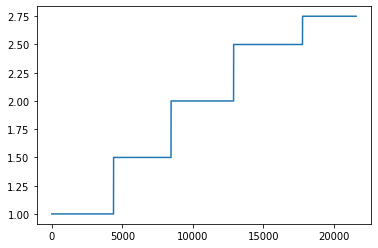

In [10]:
tf = df.copy()

def set_to_avg(df, a, b, col, val):
    idx = (df[col] > a) & (df[col] < b)
    avg = (df.loc[idx])[col].mean()
    df.loc[idx,col] = val
    return df
    
# tf = set_to_avg(tf, -30.0, -20.5, 'DRR', 1.)
# tf = set_to_avg(tf, -20.4, -18.5, 'DRR', 1.5)
# tf = set_to_avg(tf, -18.4, -16.0, 'DRR', 2.)
# tf = set_to_avg(tf, -15.9, -14.0, 'DRR', 2.5)
# tf = set_to_avg(tf, -14.0, -10.0, 'DRR', 2.75)
plt.plot(np.sort(tf['DRR']))

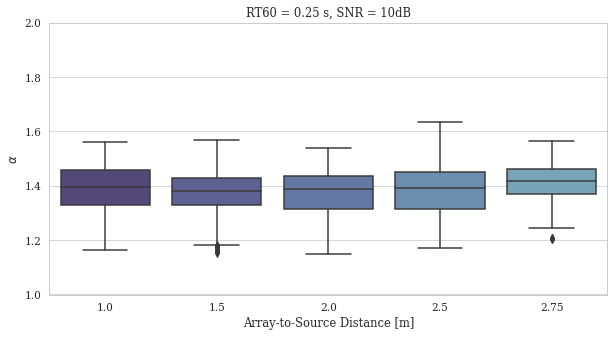

In [22]:
plt.figure(figsize=(10,5))
plt.title('RT60 = 0.25 s, SNR = 10dB')
sns.boxplot(x='DRR', y='alpha',
            data=df.loc[(df['algo'] == 'aMUSIC') & 
                        (df['alpha'] != 1.5) & (df['alpha'] != 1.8)
                       ],
           palette=pal)
plt.ylim((1,2))
plt.ylabel(r'$\alpha$')
plt.xlabel('Array-to-Source Distance [m]')
plt.savefig('../recipes/EUSIPCO22/figures/alpha_DRR.pdf',dpi=300)
plt.show()

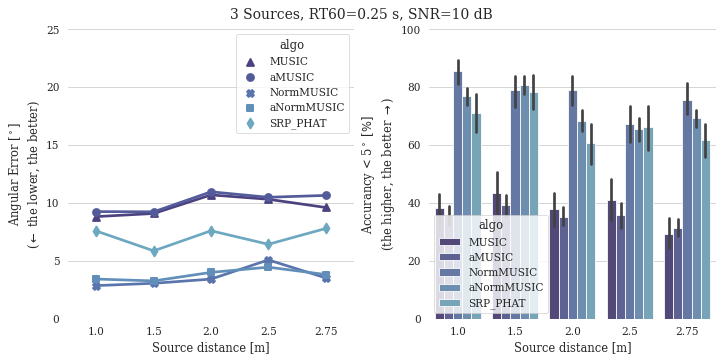

In [20]:
curr_df = df.loc[((df['alpha'] != 1.5) | (df['alpha'] != 1.8)) & (df['p'] != 1)]

for n_srcs in [3]:
    plt.figure(figsize=(10,5))
    plt.suptitle(f'{n_srcs} Sources, RT60=0.25 s, SNR=10 dB')
    plt.subplot(121)
    sns.pointplot(x='DRR', y='MAE', hue='algo', 
                  palette=pal,
                  data=curr_df.loc[curr_df['n_srcs'] == n_srcs],
                  markers=['^','o','X','s','d','v','*'],
                  ci=None
    )
    plt.ylim([0,25])
    plt.ylabel('Angular Error [$^\circ$]\n' + r'($\leftarrow$ the lower, the better)')
    plt.xlabel('Source distance [m]')
    
    plt.subplot(122)
    sns.barplot(x='DRR', y='ACC5', hue='algo', 
                palette=pal,
                data=curr_df.loc[curr_df['n_srcs'] == n_srcs],
    )
    plt.ylim([0,100])
    plt.ylabel('Accurancy < 5$^\circ$ [$\%$]\n'+ r'(the higher, the better $\rightarrow$)')
    plt.xlabel('Source distance [m]')
    sns.despine(offset=10, trim=False, left=True, bottom=True)
    plt.tight_layout(pad=0.5)
plt.savefig('../recipes/EUSIPCO22/figures/mae_acc_3srcs_DRR.pdf',dpi=300)
plt.show()

In [ ]:
# for n_srcs in [1,2,3,4]:
#     plt.figure(figsize=(20,5))
#     plt.subplot(131)
#     plt.title(f'n_srcs {n_srcs}')
#     sns.pointplot(x='DRR', y='MAE', hue='algo', 
#                   palette=pal,
#                   data=df.loc[df['n_srcs'] == n_srcs],
#                   markers=['^','o','X','s','d','v','*'],
#                   ci=None
#     )
#     plt.subplot(132)
#     sns.barplot(x='DRR', y='ACC5', hue='algo', 
#                 palette=pal,
#                 data=df.loc[df['n_srcs'] == n_srcs],
#     )
#     plt.subplot(133)
#     sns.barplot(x='DRR', y='MISS', hue='algo', 
#                 palette=pal,
#                 data=df.loc[df['n_srcs'] == n_srcs],
#     )
    
#     plt.tight_layout()